In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kusam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [3]:
!python -m pip install -U gensim

Requirement already up-to-date: gensim in c:\users\kusam\anaconda3\lib\site-packages (3.8.3)


In [4]:
conda install -c conda-forge pyldavis

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



C:\Users\kusam\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [6]:
df = pd.read_csv('HK_Reviews.csv', header = 1)
df.head()
len(df)

880

In [7]:
df.isna().any()

s.no                       False
Media                      False
Reviewer Name               True
Reviews                     True
Rating                     False
Response from the Owner     True
Comment                     True
Safety                      True
Sanity                      True
Customer Service            True
Party                       True
Unnamed: 11                 True
Unnamed: 12                 True
dtype: bool

In [8]:
df = df[df['Reviews'].notna()]
len(df)

875

In [9]:
df.isna().any()

s.no                       False
Media                      False
Reviewer Name              False
Reviews                    False
Rating                     False
Response from the Owner     True
Comment                     True
Safety                      True
Sanity                      True
Customer Service            True
Party                       True
Unnamed: 11                 True
Unnamed: 12                 True
dtype: bool

In [10]:
df.drop(['Comment','Safety','Sanity','Customer Service', 'Party', 'Unnamed: 11', 'Unnamed: 12'],axis=1, inplace=True)

In [11]:
df.head()

,s.no,Media,Reviewer Name,Reviews,Rating,Response from the Owner
0,1,Yelp,"Jessie L.\r\nBaltimore, MD","For those of you not aware, there is a recent occurrence on 4/9/18 with Hyper Kidz that is causing me to regret the purchase of a two-visit CertifiKID voucher. In summary, a mother complained tha...",1,"4/12/2018 Jessica, incident as you describe it here (and on many other social media platforms) is a falsehood. In speaking with the mother personally, she stated that she was never told that she ..."
1,2,Google,Alb FW,"What A ‘Racial discriminating’ place!!!! Basically if you are Jewish you can do anything you want, you can bring whole lot outside food and sit at the table and enjoy your meal, and you will just ...",1 Star,"Hello Alb, we are sorry that you feel this way. However, we respectfully and completely deny your claims and allegations. First, we are not in the business of picking out and profiling which custo..."
2,3,Google,\r\nAutumn Schultheis,"This will be a long one so sorry ahead of time. My family and I arrived at Hyper Kidz around 2pm on a Sunday. While I was fully prepared for a possible wait, I was not expecting the horrible custo...",1 Star,"Hi Autumn,\r\nMy name is Melissa I’m the general manager here at Hyper kidz. First let me start of by saying sorry about your experience at Hyper Kidz. Also I apologize about the missed call. Yes ..."
3,4,Google,Christine Meador,I was very disappointed with my visit to hyper kidz in Columbia. None of the little rides were operational. Things were taped up. Some of the structures had caution tape. I don’t know how they are...,1 Star,Hi Christine our manager Melissa will be reaching out to you. We are very sorry about your experience.
4,5,Google,Ruth Ann Healey,The place was horrible! It was way over crowded. It was hard to even find the place or parking. It was too expensive. The party room was small and it was extremely hot with nowhere for adults to s...,1 star,"Hi Ruth,\nI’m sorry about your experience at Hyper Kidz. Great news we are expanding. Yes weekends do get busy for various reason. Have a wonderful day."


In [12]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

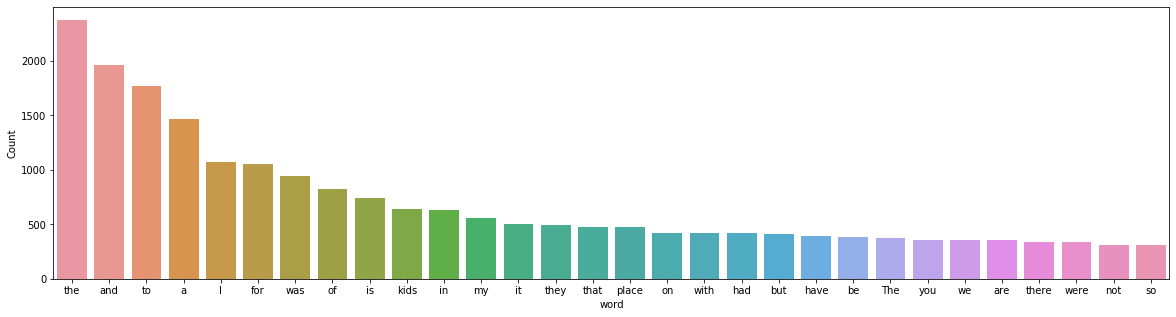

In [13]:
freq_words(df['Reviews'])

In [14]:
# remove unwanted characters, numbers and symbols
df['Reviews'] = df['Reviews'].str.replace("[^a-zA-Z#]", " ")

In [15]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [16]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['Reviews'] = df['Reviews'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['Reviews']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

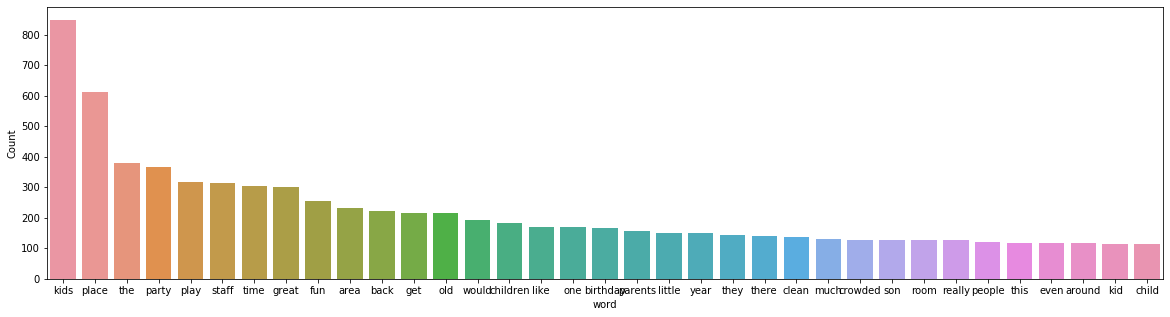

In [17]:
freq_words(reviews, 35)

In [18]:
!python -m spacy download en 

symbolic link created for C:\Users\kusam\Anaconda3\lib\site-packages\spacy\data\en <<===>> C:\Users\kusam\Anaconda3\lib\site-packages\en_core_web_sm
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[+] Linking successful
C:\Users\kusam\Anaconda3\lib\site-packages\en_core_web_sm -->
C:\Users\kusam\Anaconda3\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


In [19]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [20]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['what', 'racial', 'discriminating', 'place', 'basically', 'jewish', 'anything', 'want', 'bring', 'whole', 'lot', 'outside', 'food', 'sit', 'table', 'enjoy', 'meal', 'tell', 'customers', 'eat', 'inside', 'bag', 'chips', 'fine', 'hehe', 'older', 'jewish', 'kids', 'like', 'jump', 'water', 'pad', 'zone', 'told', 'stop', 'bunch', 'older', 'kids', 'play', 'zone', 'kicked', 'son', 'even', 'use', 'rotating', 'facility', 'sphere', 'throw', 'son', 'head', 'right', 'way', 'got', 'told', 'son', 'spitting', 'mean', 'bully', 'old', 'son', 'anything', 'fight', 'back', 'speechless', 'shameful']


In [21]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['racial', 'place', 'jewish', 'whole', 'lot', 'food', 'sit', 'table', 'enjoy', 'meal', 'customer', 'bag', 'chip', 'fine', 'old', 'jewish', 'kid', 'jump', 'water', 'pad', 'zone', 'old', 'kid', 'zone', 'son', 'facility', 'sphere', 'son', 'right', 'way', 'son', 'old', 'speechless', 'shameful']


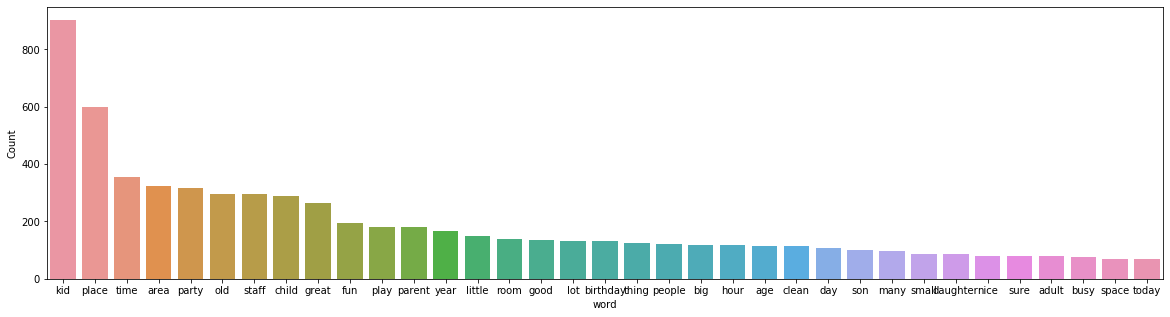

In [22]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

In [23]:
dictionary = corpora.Dictionary(reviews_2)

In [24]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [25]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [26]:
lda_model.print_topics()

[(0,
  '0.044*"kid" + 0.032*"party" + 0.032*"time" + 0.028*"place" + 0.015*"birthday" + 0.013*"hour" + 0.012*"shoe" + 0.011*"play" + 0.010*"great" + 0.009*"free"'),
 (1,
  '0.023*"play" + 0.021*"child" + 0.020*"old" + 0.017*"staff" + 0.016*"adult" + 0.012*"kid" + 0.012*"time" + 0.011*"good" + 0.011*"area" + 0.010*"space"'),
 (2,
  '0.017*"time" + 0.017*"awesome" + 0.015*"place" + 0.014*"small" + 0.013*"love" + 0.013*"hour" + 0.012*"kid" + 0.007*"packed" + 0.006*"facility" + 0.006*"first"'),
 (3,
  '0.058*"party" + 0.023*"place" + 0.022*"room" + 0.020*"kid" + 0.019*"child" + 0.017*"time" + 0.016*"area" + 0.016*"birthday" + 0.012*"staff" + 0.012*"food"'),
 (4,
  '0.083*"kid" + 0.032*"place" + 0.026*"area" + 0.022*"parent" + 0.014*"time" + 0.013*"play" + 0.012*"old" + 0.011*"child" + 0.010*"good" + 0.009*"people"'),
 (5,
  '0.021*"party" + 0.021*"birthday" + 0.015*"place" + 0.009*"unorganized" + 0.008*"system" + 0.008*"wonderful" + 0.008*"good" + 0.008*"cousin" + 0.008*"time" + 0.007*"kid

In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\kusam\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.146233 -0.035557       1        1  44.829697
3     -0.040180  0.140970       2        1  21.758760
4     -0.104559 -0.054406       3        1  16.369568
0     -0.004332  0.073621       4        1   7.293919
1      0.004036 -0.090618       5        1   5.678114
2      0.140707 -0.058974       6        1   2.058782
5      0.150561  0.024964       7        1   2.011156, topic_info=     Category        Freq      Term       Total  loglift  logprob
79    Default  286.000000     party  286.000000  30.0000  30.0000
36    Default  822.000000       kid  822.000000  29.0000  29.0000
41    Default  547.000000     place  547.000000  28.0000  28.0000
88    Default  319.000000      time  319.000000  27.0000  27.0000
56    Default  117.000000  birthday  117.000000  26.0000  26.0000
...       ...         ...       ...         ...      ...      ...
60     Topic7    1.800972       day   97.931328  -0.0895  -5.2171
1099   Topic7    1.393407  activity   31.719055   0.7813  -5.4736
390    Topic7    1.363465    friend   26.547815   0.9375  -5.4954
58     Topic7    1.297319  capacity   47.577541   0.3044  -5.5451
13     Topic7    1.297117    public   12.607347   1.6323  -5.5452

[527 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1840      2  0.228033  absolute
1840      5  0.228033  absolute
1840      6  0.456065  absolute
0         7  0.710081     abuse
1876      5  0.624985   abusive
...     ...       ...       ...
185       5  0.064920      year
266       1  0.706547     young
266       2  0.090583     young
266       3  0.181166     young
266       4  0.036233     young

[971 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 5, 1, 2, 3, 6])